# Identifying Customer Segments

In this project, I will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. I have two datasets: one with demographic information about the people of Germany, and one with that same information for customers of the mail-order sales company. I will look at relationships between demographics features, organize the population into clusters, and see how prevalent customers are in each of the segments obtained. These segments could then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. 

The data that I will use for this project has been provided to me by _[Bertelsmann Arvato Analytics](https://www.arvato.com/in-en/solutions/big-data-analytics.html)_.

In [1]:
# Import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter

# Magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I will use this information to cluster the general population into groups with similar demographic properties. Then, I will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Check demographics data
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
# Check feature data
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [7]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,WOHNLAGE,person,ordinal,[-1]
freq,1,43,49,26


In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


So for example, in the 'AGER_TYP' column we will need to replace any values. If we look at the first few rows of the demographics data again...

In [9]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


We can see that we have 4 examples of 'encoded' NaN values (as -1) for 'AGER_TYP' in the first 5 rows, we can use this to check if our replacement has worked later.

In [10]:
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I will use this file to help make cleaning decisions during this stage of the project. First of all, I will assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. I will need to do a little bit of parsing to make use of it to identify and clean the data. I will then convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. 

In [11]:
# Identify missing or unknown data values and convert them to NaNs.
# Check currently missing data in whole of demographics data
azdias.isnull().values.sum()

4896838

Thats a lot of missing values, nearly 5 million cells out of around (85 x 891221) approx 75 million cells. So around 7% of cells currrently, before converting other encoded missing values.

In [12]:
# Check currently missing data per column of demographics data
azdias.isnull().sum(axis = 0)

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

These missing values seem to be concerntrated in particilar columns, some more than others (ie the KBA05.. columns). Some columns have no missing values at all.

In [13]:
# Now convert encoded missing data into NaN's

def replace_missing_with_NAN(data_df):
    
    # For each feature
    for index, row in feat_info.iterrows():

        # Check if we have values to replace with NaN
        encodedNans = row['missing_or_unknown'].strip()
        encodedNans = re.sub(r'[\[\]]','',encodedNans)

        # If we have values to replace for this column
        if encodedNans:

            # Convert values into a list
            encodedNansList = encodedNans.split(",")
            # For each value to replace
            for encodedNanValue in encodedNansList:

                # Get corresponding column name in demographics data
                column = row['attribute']    
                # Cast value to correct type for this column if needed
                if data_df[column].dtype == np.int64:
                    encodedNanValue = int(encodedNanValue) 
                if data_df[column].dtype == np.float64:
                    encodedNanValue = float(encodedNanValue) 
                # Replace with NaN in corresponding column in demographics data
                data_df[column] = data_df[column].replace({encodedNanValue: np.nan})
    # Return df           
    return data_df
            
azdias = replace_missing_with_NAN(azdias)

In [14]:
# Lets now check the first few rows to see if it has replaced for the 'AGER_TYP' column the -1 values with NaN
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. I will identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project 
I will remove them from the dataframe.

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Lets relook at total missing cells for all columns
azdias.isnull().values.sum()

8373929

So this has now increased from 4896838 to 8373929. How about the total missing data per column...

In [16]:
# Missing data per column after replacing encoded NaN values
missing_data_columns = azdias.isnull().sum()[azdias.isnull().sum() != 0]
missing_data_columns

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SHOPPER_TYP              111196
SOHO_KZ                   73499
TITEL_KZ                 889061
VERS_TYP                 111196
ALTER_HH                 310267
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
HH_EINKOMMEN_SCORE        18348
KK_KUNDENTYP             584612
W_KEIT_KIND_HH           147988
WOHNDAUER_2008            73499
ANZ_HAUSHALTE_AKTIV       99611
ANZ_HH_TITEL              97008
GEBAEUDETYP               93148
KONSUMNAEHE               73969
                          ...  
OST_WEST

In [17]:
# Lets get some useful stats like a percentage as well as total missing to get a sense of proportion of values missing
missing_data_dict = {'total': missing_data_columns.values, 'percentage': np.round((missing_data_columns.values *100) / 891221, 2)}
missing_columns_df = pd.DataFrame(data=missing_data_dict, index=missing_data_columns.index)
missing_columns_df = missing_columns_df.sort_values(by='percentage', ascending=False)
missing_columns_df

,percentage,total
TITEL_KZ,99.76,889061
AGER_TYP,76.96,685843
KK_KUNDENTYP,65.60,584612
KBA05_BAUMAX,53.47,476524
GEBURTSJAHR,44.02,392318
ALTER_HH,34.81,310267
KKK,17.74,158064
REGIOTYP,17.74,158064
W_KEIT_KIND_HH,16.61,147988
KBA05_ANTG3,14.96,133324


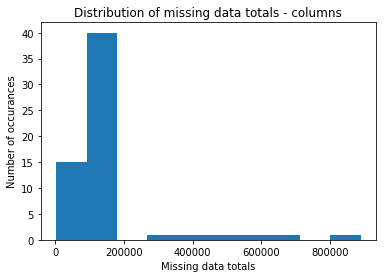

In [18]:
# Investigate patterns in the amount of missing data in each column.

# Lets plot the distribution of totals of missing values
plt.figure();
plt.xlabel('Missing data totals')
plt.ylabel('Number of occurances')
plt.title('Distribution of missing data totals - columns')
plt.hist(missing_columns_df['total']);

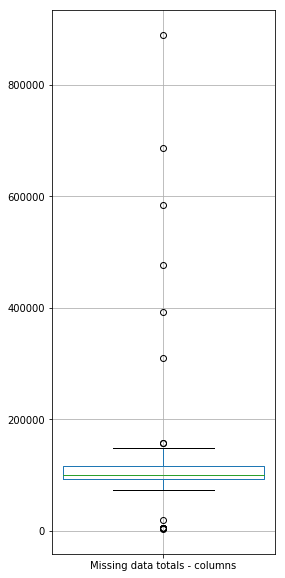

In [19]:
# Lets look at the same distribution in a different way, using a box and whisker plot
dist_compare = pd.DataFrame()
dist_compare['Missing data totals - columns'] = missing_columns_df['total']
dist_compare.boxplot(figsize=(4,10), grid=True, widths=0.9)
plt.figure();

We can see this distribution seems to form 2 different groups, below 200,000 which has the bulk of the distribution, and a few values above 200,000. Lets consider 200,000 as the divison point between the normal values and outlier values, and lets look at each group individually to understand each better.

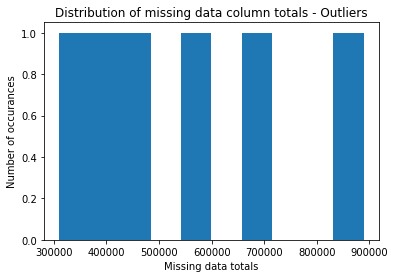

In [20]:
# Get outlier columns
outliers_columns_df = missing_columns_df[missing_columns_df['total']>200000]
# Look at the distribution of outlier columns
plt.figure();
plt.xlabel('Missing data totals')
plt.ylabel('Number of occurances')
plt.title('Distribution of missing data column totals - Outliers')
plt.hist(outliers_columns_df['total']);

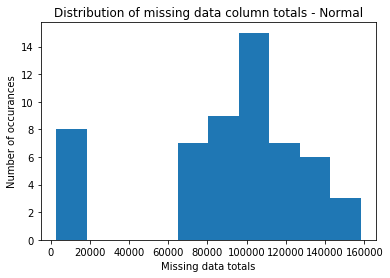

In [21]:
# Get normal columns
normal_columns_df = missing_columns_df[missing_columns_df['total']<200000]
# Look at the distribution of normal columns
plt.figure();
plt.xlabel('Missing data totals')
plt.ylabel('Number of occurances')
plt.title('Distribution of missing data column totals - Normal')
plt.hist(normal_columns_df['total']);

In [22]:
# List outlier columns
outliers_columns_df

,percentage,total
TITEL_KZ,99.76,889061
AGER_TYP,76.96,685843
KK_KUNDENTYP,65.60,584612
KBA05_BAUMAX,53.47,476524
GEBURTSJAHR,44.02,392318
ALTER_HH,34.81,310267


In [23]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR', 'GEBURTSJAHR', 'ALTER_HH'], axis=1)
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

#### Discussion 1.1.2: Assess Missing Data in Each Column

We can see in the histogram above that the bulk of the distribution of missing data totals is of values less than 200,000. In other words, between 0 and 200,000 we could consider as being the normal range of missing data. 

So I will consider outlier columns as those who have missing data of more than 200,000.

The general patterns I observed in the missing data totals are:

- 0 - 200,000 missing data: we have 2 groups, 8 occurances with values under 20,000, and a larger group of values from around 70,000 to 160,000 missing data values
- 200,000+ missing data: we have 4 single occurances with different totals

I removed the following columns from the dataset that had missing data totals of more than 200,000

- TITEL_KZ
- AGER_TYP
- KK_KUNDENTYP
- KBA05_BAUMAX
- GEBURTSJAHR
- ALTER_HH	

#### Step 1.1.3: Assess Missing Data in Each Row

Now I will perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, might see some groups of points that have a very different numbers of missing values. I will divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. I will select at least five of these columns and compare the distribution of values.

Depending on what I observe in my comparison, this will have implications on how I approach my conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, I will continue my analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# How much data is missing in each row of the dataset?

# Calculate total missing for each row
missing_data_rows = azdias.isnull().sum(axis = 1)
# Create dataframe to plot total missing
missing_data_rows_dict = {'total': missing_data_rows.values}
missing_rows_df = pd.DataFrame(data=missing_data_rows_dict, index=missing_data_rows.index)

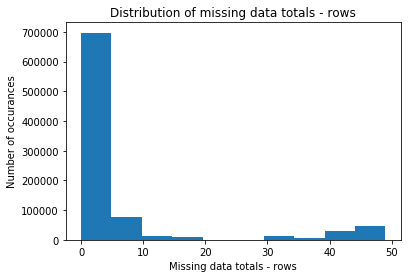

In [25]:
# Lets plot the distribution of totals of missing values for rows
plt.figure();
plt.xlabel('Missing data totals - rows')
plt.ylabel('Number of occurances')
plt.title('Distribution of missing data totals - rows')
plt.hist(missing_rows_df['total']);

Based on my observations above, I will choose the dividing point between the two subsets of normal & outlier values
as 25 missing values.

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Get normal rows indexes
normal_rows_indexes = azdias.isnull().sum(axis = 1)[azdias.isnull().sum(axis = 1) <= 25]

# Get outlier rows indexes
outlier_rows_indexes = azdias.isnull().sum(axis = 1)[azdias.isnull().sum(axis = 1) > 25]
    
# Get normal rows data subset
normal_rows_df = azdias.drop(outlier_rows_indexes.index)

# Get outlier rows data subset
outlier_rows_df = azdias.drop(normal_rows_indexes.index)

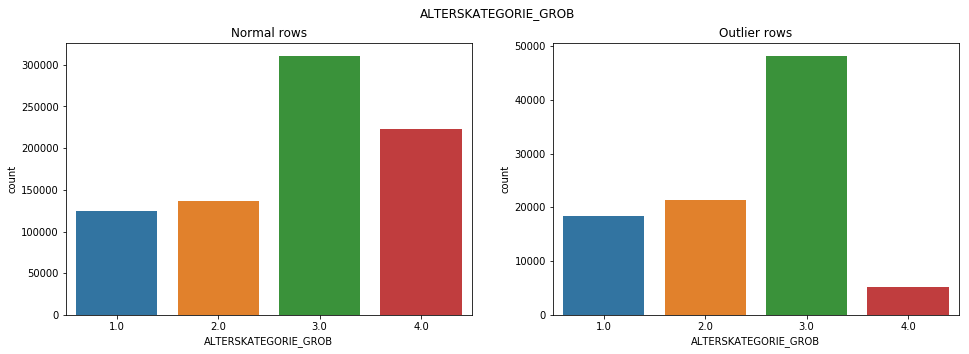

In [27]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_columns_nans(column, normal_df, outliers_df):
    
    # Plot comparison histograms
    fig = plt.figure(figsize=(16,5))
    plot1 = fig.add_subplot(121)
    plot1.title.set_text('Normal rows')
    sns.countplot(normal_df[column])

    plot2 = fig.add_subplot(122)
    plot2.title.set_text('Outlier rows')
    sns.countplot(outliers_df[column])

    fig.suptitle(column)
    plt.show()

# Check first random column
compare_columns_nans('ALTERSKATEGORIE_GROB', normal_rows_df, outlier_rows_df)

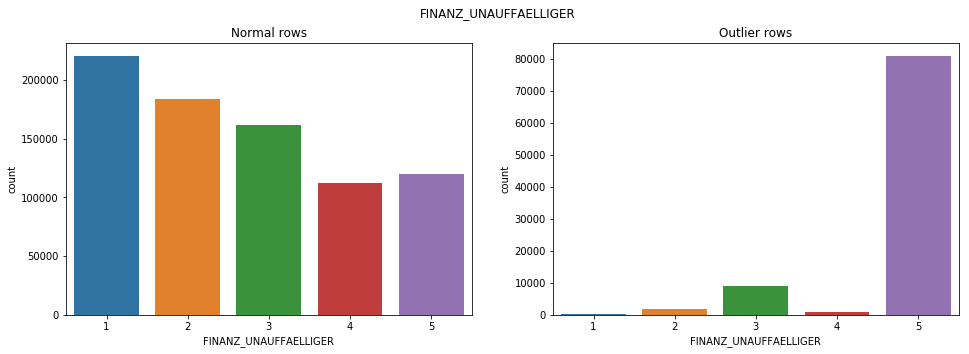

In [28]:
# Check second random column
compare_columns_nans('FINANZ_UNAUFFAELLIGER', normal_rows_df, outlier_rows_df)

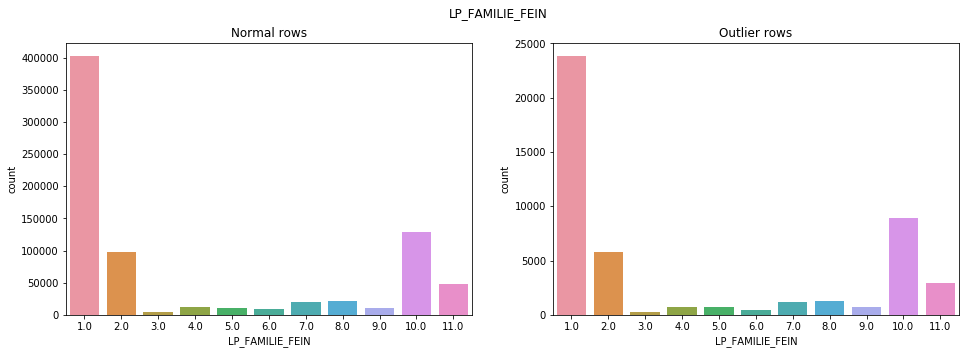

In [29]:
# Check third random column
compare_columns_nans('LP_FAMILIE_FEIN', normal_rows_df, outlier_rows_df)

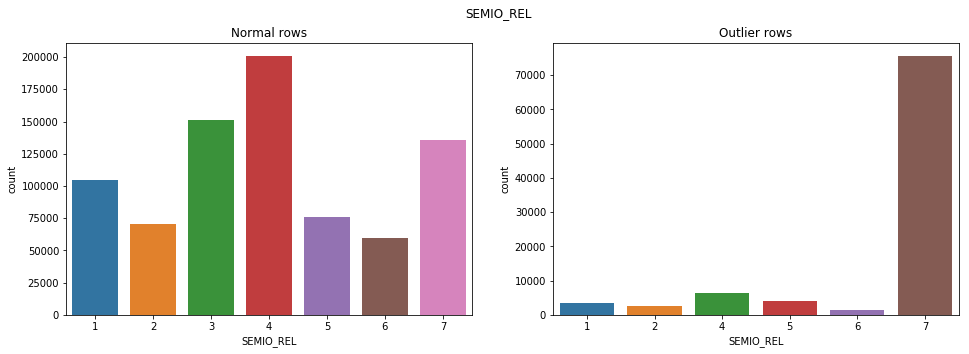

In [30]:
# Check fouth random column
compare_columns_nans('SEMIO_REL', normal_rows_df, outlier_rows_df)

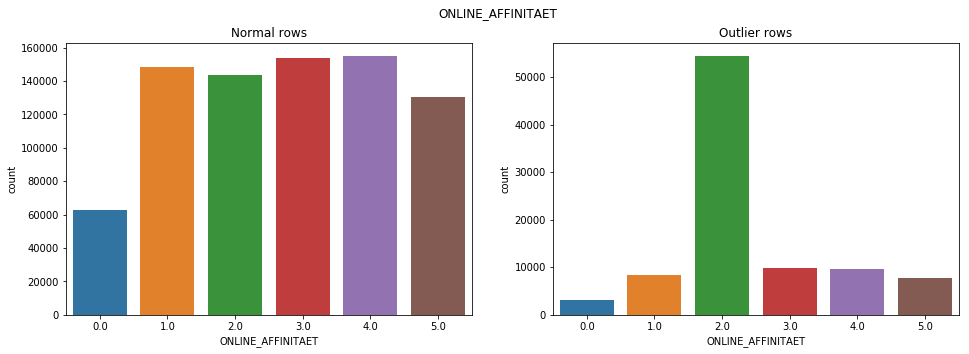

In [31]:
# Check fifth random column
compare_columns_nans('ONLINE_AFFINITAET', normal_rows_df, outlier_rows_df)

In [32]:
# Drop outlier rows with more than 25 missing values per row
azdias = azdias.drop(outlier_rows_indexes.index, axis=0)
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797961 entries, 1 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     795160 non-null float64
ANREDE_KZ                797961 non-null int64
CJT_GESAMTTYP            793248 non-null float64
FINANZ_MINIMALIST        797961 non-null int64
FINANZ_SPARER            797961 non-null int64
FINANZ_VORSORGER         797961 non-null int64
FINANZ_ANLEGER           797961 non-null int64
FINANZ_UNAUFFAELLIGER    797961 non-null int64
FINANZ_HAUSBAUER         797961 non-null int64
FINANZTYP                797961 non-null int64
GFK_URLAUBERTYP          793248 non-null float64
GREEN_AVANTGARDE         797961 non-null int64
HEALTH_TYP               761281 non-null float64
LP_LEBENSPHASE_FEIN      747828 non-null float64
LP_LEBENSPHASE_GROB      750714 non-null float64
LP_FAMILIE_FEIN          766564 non-null float64
LP_FAMILIE_GROB          766564 non-null float64
LP_STATUS_FEIN           793248 non-null float64
LP_STATUS_GROB           

#### Discussion 1.1.3: Assess Missing Data in Each Row

From the 5 columns I examined, 2 columns had similar distributions of values between the normal & outliers subsets (ALTERSKATEGORIE_GROB and LP_FAMILIE_FEIN), whereas 3 columns had very different distributions between the two subsets (FINANZ_UNAUFFAELLIGER, SEMIO_REL, ONLINE_AFFINITAET). 

Because 3 out of 5 columns have different distributions, this suggests that the outliers subset may well have unique features and characteristics.

For now we will take note of this, but continue by excluding the outlier subset.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

In the first two parts of this sub-step, I will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether I will keep, drop, or re-encode each. Then, in the last part, I will create a new data frame with only the selected and engineered columns.

In [33]:
# Extract columns removed earlier in cleaning process
feat_removed = feat_info.loc[~feat_info['attribute'].isin(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'])]
# How many features are there remaining of each data type?
feat_removed['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, I will perform one of the following:
- For binary (two-level) categoricals that take numeric values, keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, I need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), I could choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. 

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Extract column names of categorical type 
categorical_columns_df = feat_removed.loc[feat_removed['type'] == 'categorical']
# Filter data for these categorical columns
categorical_data_df = azdias.filter(items=categorical_columns_df['attribute'].values)
# Get distinct values for these columns
distinct_categories={}
for col in categorical_data_df:
    distinct_categories[col] = categorical_data_df[col].unique()
distinct_categories

{'ANREDE_KZ': array([2, 1]),
 'CJT_GESAMTTYP': array([  5.,   3.,   2.,   4.,   1.,   6.,  nan]),
 'FINANZTYP': array([1, 6, 5, 2, 4, 3]),
 'GFK_URLAUBERTYP': array([ 10.,   1.,   5.,  12.,   9.,   3.,   8.,  11.,   4.,   2.,   7.,
          6.,  nan]),
 'GREEN_AVANTGARDE': array([0, 1]),
 'LP_FAMILIE_FEIN': array([  5.,   1.,  nan,  10.,   2.,   7.,  11.,   8.,   4.,   6.,   9.,
          3.]),
 'LP_FAMILIE_GROB': array([  3.,   1.,  nan,   5.,   2.,   4.]),
 'LP_STATUS_FEIN': array([  2.,   3.,   9.,   4.,   1.,  10.,   5.,   8.,   6.,   7.,  nan]),
 'LP_STATUS_GROB': array([  1.,   2.,   4.,   5.,   3.,  nan]),
 'NATIONALITAET_KZ': array([  1.,   3.,   2.,  nan]),
 'SHOPPER_TYP': array([  3.,   2.,   1.,   0.,  nan]),
 'SOHO_KZ': array([ 1.,  0.]),
 'VERS_TYP': array([  2.,   1.,  nan]),
 'ZABEOTYP': array([5, 3, 4, 1, 6, 2]),
 'GEBAEUDETYP': array([ 8.,  1.,  3.,  2.,  6.,  4.,  5.]),
 'OST_WEST_KZ': array(['W', 'O'], dtype=object),
 'CAMEO_DEUG_2015': array(['8', '4', '2', '6', '1

Looking at our categorical variables we have:

- Numeric binary categorical columns: ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP
- Non-numeric binary categorical column: OST_WEST_KZ

The rest are multi-level categoricals.

In [35]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Re-encode binary non-numeric categorical columns 
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace('W', '1')
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace('O', '0')
# Convert column to int
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].astype(int)
azdias['OST_WEST_KZ'].head()

1    1
2    1
3    1
4    1
5    1
Name: OST_WEST_KZ, dtype: int64

In [36]:
# Extract column names of multi-level categorical type (filter out binary cat columns)
cat_multi_columns_df = categorical_columns_df.loc[~categorical_columns_df['attribute'].isin(['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP','OST_WEST_KZ'])]
cat_multi_col_names = cat_multi_columns_df['attribute'].values
# Drop them
azdias = azdias.drop(cat_multi_col_names, axis=1)


In [37]:
# Show names of columns dropped
cat_multi_col_names

array(['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

#### Discussion 1.2.1: Re-Encode Categorical Features

In this section I discovered there were 18 categorical features: 5 binary categorical and 13 multi-level. One of the binary features (OST_WEST_K) was non-numeric.

For OST_WEST_K, I first searched and replaced it's binary values to 1 and 0, and then converted the column to integer type. For the multi-level categorical fields, I decided to drop them - in which case I end up with a dataset with around 60 odd features. If I had chosen to re-encode these multi-category fields I would have ended up with a dataset of nearly 200 features - which might have been much harder to cluster and derive meaningful insight - so in this case I have chosen the path - less is more!

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. I will break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Lets look at the unique values for this feature
azdias['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [39]:
# Create lambda function that will map from PRAEGENDE_JUGENDJAHRE feature to new decade feature
def pj_to_decade (row):
    if row['PRAEGENDE_JUGENDJAHRE'] in (1,2): # Decade: 40s
        return 1
    if row['PRAEGENDE_JUGENDJAHRE'] in (3,4): # Decade: 50s
        return 2
    if row['PRAEGENDE_JUGENDJAHRE'] in (5,6,7): # Decade: 60s
        return 3
    if row['PRAEGENDE_JUGENDJAHRE'] in (8,9): # Decade: 70s
        return 4
    if row['PRAEGENDE_JUGENDJAHRE'] in (10,11,12,13): # Decade: 80s
        return 5
    if row['PRAEGENDE_JUGENDJAHRE'] in (14,15): # Decade: 90s
        return 6
    
# Create new decade feature/column using lambda function
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias.apply (lambda row: pj_to_decade(row), axis=1)

In [40]:
# Lets check the unique values of our new variable
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'].unique()

array([  6.,   4.,   2.,   5.,   3.,  nan,   1.])

In [41]:
# Create lambda function that will map from PRAEGENDE_JUGENDJAHRE feature to new movement feature
def pj_to_movement (row):
    if row['PRAEGENDE_JUGENDJAHRE'] in (1,3,5,8,10,12,14): # Movement: Mainstream
        return 0
    if row['PRAEGENDE_JUGENDJAHRE'] in (2,4,6,7,9,11,13,15): # Movement: Avantgarde
        return 1
    
# Create new decade feature/column using lambda function
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias.apply (lambda row: pj_to_movement(row), axis=1)

In [42]:
# Lets check the unique values of our new variable
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].unique()

array([  0.,   1.,  nan])

In [43]:
# With both new features extracted succesfully, we can drop the original column
azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [44]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Lets look at the unique values for this feature
azdias['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [45]:
# We will need to manipulate as integers to make new fields, so lets replace XX & Nan, and convert type
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace({'XX': 0})
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace({np.nan: 0})
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(int)
# Check unique values again and column type
azdias['CAMEO_INTL_2015'].unique()

array([51, 24, 12, 43, 54, 22, 14, 13, 15, 33, 41, 34, 55,  0, 25, 23, 31,
       52, 35, 45, 44, 32])

In [46]:
# Create lambda function that will map from CAMEO_INTL_2015 feature to new wealth feature
def ci2015_to_wealth (row):
    if row['CAMEO_INTL_2015'] // 10 == 1: # Wealthy Households
        return 1
    if row['CAMEO_INTL_2015'] // 10 == 2: # Prosperous Households
        return 2
    if row['CAMEO_INTL_2015'] // 10 == 3: # Comfortable Households
        return 3
    if row['CAMEO_INTL_2015'] // 10 == 4: # Less Affluent Households
        return 4
    if row['CAMEO_INTL_2015'] // 10 == 5: # Poorer Households
        return 5
    
# Create new wealth feature/column using lambda function
azdias['CAMEO_INTL_2015_WEALTH'] = azdias.apply (lambda row: ci2015_to_wealth(row), axis=1)

In [47]:
# Lets check the unique values of our new variable
azdias['CAMEO_INTL_2015_WEALTH'].unique()

array([  5.,   2.,   1.,   4.,   3.,  nan])

In [48]:
# Create lambda function that will map from CAMEO_INTL_2015 feature to new life stage feature
def ci2015_to_lifestage (row):
    if row['CAMEO_INTL_2015'] % 10 == 1: # Pre-Family Couples & Singles
        return 1
    if row['CAMEO_INTL_2015'] % 10 == 2: # Young Couples With Children
        return 2
    if row['CAMEO_INTL_2015'] % 10 == 3: # Families With School Age Children
        return 3
    if row['CAMEO_INTL_2015'] % 10 == 4: # Older Families &  Mature Couples
        return 4
    if row['CAMEO_INTL_2015'] % 10 == 5: # Elders In Retirement
        return 5
    
# Create new life stage feature/column using lambda function
azdias['CAMEO_INTL_2015_LIFESTAGE'] = azdias.apply (lambda row: ci2015_to_lifestage(row), axis=1)

In [49]:
# Lets check the unique values of our new variable
azdias['CAMEO_INTL_2015_LIFESTAGE'].unique()

array([  1.,   4.,   2.,   3.,   5.,  nan])

In [50]:
# With both new features extracted succesfully, we can drop the original column
azdias = azdias.drop('CAMEO_INTL_2015', axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

PRAEGENDE_JUGENDJAHRE

From this feature, I created two new features PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT which encapsulate sub-features within the orginal. Once these were created, I dropped the original PRAEGENDE_JUGENDJAHRE feature. Note, the original feature contained 'unknown' values which translated into nan values in the new features. We will need to deal with these before proceeding to further stages.

CAMEO_INTL_2015

From this feature, I created two new features CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFESTAGE which encapsulate sub-features within the orginal. Once these were created, I dropped the original CAMEO_INTL_2015 feature. Note, the original feature contained 'unknown' values (as nan and XX) which translated into nan values in the new features. We will need to deal with these before proceeding to further stages.

### Step 1.3: Create a Cleaning Function

Even though I have finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that I will need to perform the same cleaning steps on the customer demographics data. In this substep, I will complete the function below to execute the main feature selection, encoding, and re-engineering steps I performed above. Then, when it comes to looking at the customer data in Step 3, I can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [53]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    clean_df = replace_missing_with_NAN(df)
    
    # remove selected columns and rows, ...
    # Remove outlier columns
    clean_df = clean_df.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR', 'GEBURTSJAHR','ALTER_HH'], axis=1)
    # Remove outlier rows
    outlier_rows_indexes = clean_df.isnull().sum(axis = 1)[clean_df.isnull().sum(axis = 1) > 25]
    clean_df = clean_df.drop(outlier_rows_indexes.index, axis=0)
    
    
    # select, re-encode, and engineer column values.
    # Re-encode binary non-numeric categorical columns 
    clean_df['OST_WEST_KZ'] = clean_df['OST_WEST_KZ'].replace('W', '1')
    clean_df['OST_WEST_KZ'] = clean_df['OST_WEST_KZ'].replace('O', '0')
    # Convert column to int
    clean_df['OST_WEST_KZ'] = clean_df['OST_WEST_KZ'].astype(int)
    # Extract remaining columns/features (remove columns lost earlier in cleaning process)
    remaining_feat = feat_info.loc[~feat_info['attribute'].isin(outliers_columns_df.index)]
    # Extract column names of categorical type 
    categorical_columns_df = remaining_feat.loc[remaining_feat['type'] == 'categorical']
    # Extract column names of multi-level categorical type (filter out binary cat columns)
    cat_multi_columns_df = categorical_columns_df.loc[~categorical_columns_df['attribute'].isin(['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP','OST_WEST_KZ'])]
    cat_multi_col_names = cat_multi_columns_df['attribute'].values
    # Drop multi-level categorical columns 
    clean_df = clean_df.drop(cat_multi_col_names, axis=1)
    
    # Engineer new features
    # Create new decade feature/column using lambda function
    clean_df['PRAEGENDE_JUGENDJAHRE_DECADE'] = clean_df.apply (lambda row: pj_to_decade(row), axis=1)
    # Create new decade feature/column using lambda function
    clean_df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = clean_df.apply (lambda row: pj_to_movement(row), axis=1)
    # We will need to manipulate as integers to make new fields, so lets replace XX & Nan, and convert type
    clean_df['CAMEO_INTL_2015'] = clean_df['CAMEO_INTL_2015'].replace({'XX': 0})
    clean_df['CAMEO_INTL_2015'] = clean_df['CAMEO_INTL_2015'].replace({np.nan: 0})
    clean_df['CAMEO_INTL_2015'] = clean_df['CAMEO_INTL_2015'].astype(int)
    # Create new wealth feature/column using lambda function
    clean_df['CAMEO_INTL_2015_WEALTH'] = clean_df.apply (lambda row: ci2015_to_wealth(row), axis=1)
    # Create new life stage feature/column using lambda function
    clean_df['CAMEO_INTL_2015_LIFESTAGE'] = clean_df.apply (lambda row: ci2015_to_lifestage(row), axis=1)
    # With both new features extracted succesfully, we can drop the original column
    clean_df = clean_df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    # With both new features extracted succesfully, we can drop the original column
    clean_df = clean_df.drop('CAMEO_INTL_2015', axis=1)
    
    # Return the cleaned dataframe.
    return clean_df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.

In [54]:
# Lets estimate current percentage of nans in dataset
total_cells = azdias.shape[0] * azdias.shape[1]
current_nans = azdias.isnull().values.sum()
(current_nans / total_cells) * 100

1.6252821437462261

Ok thats pretty good. Lets impute the missing values.

In [55]:
# Impute missing nan values, using median (rather than mean)
def impute_nans(df):
    fill_NaN = Imputer(missing_values=np.nan, strategy='median', axis=1)
    inputed_df = pd.DataFrame(fill_NaN.fit_transform(df))
    inputed_df.columns = df.columns
    inputed_df.index = df.index
    return inputed_df

azdias = impute_nans(azdias)
# Check Nans replaced
current_nans = azdias.isnull().values.sum()
(current_nans / total_cells) * 100

0.0

In [56]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_np = scaler.fit_transform(azdias)

### Discussion 2.1: Apply Feature Scaling

For the Nan values I decided to impute the missing values, otherwise simply deleting rows with Nans would have resulted in some loss of data.

For actually imputing the missing values, I used the median rather than mean. This is because for many of the features (such as the new CAMEO_INTL_2015_WEALTH feature) have values that should be discrete to have meaning because they are categorical ie 1.0, 2.0, 3.0. If we use mean to impute, we will get decimal values and really these have no meaning for such features. Therefore by using the median, we impute with 'center' values for the data that still have meaning especially for these categorical type numeric variables.

I used the Standard Scaler with default settings to scale and normalise the values.

### Step 2.2: Perform Dimensionality Reduction

On the scaled data, we are now ready to apply dimensionality reduction techniques. 

- I will use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, I will not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- I will observe the ratio of variance explained by each principal component as well as the cumulative variance explained. Based on what I find, I will select a value for the number of transformed features I will retain for the clustering part of the project.
- Once I have made a choice for the number of components to keep, I will need to re-fit a PCA instance to perform the decided-on transformation.

In [57]:
# Apply PCA to the data - compute all components
pca = PCA()
pca_components = pca.fit_transform(azdias_np)

In [58]:
# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
# Calulate total % explained variance for all components
variance_ratios['Explained Variance'].sum()*100

99.959999999999994

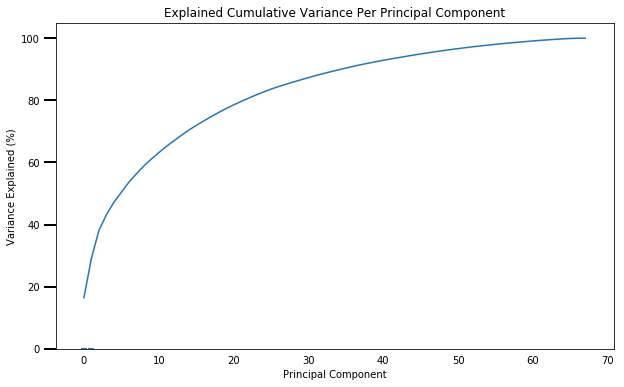

In [59]:
# Investigate the variance accounted for by each principal component.

# Utility function for showing component varience (not written by me - obtained from Udacity lesson content)
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)*100
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Cumulative Variance Per Principal Component')
    
# Investigate variance explained by pca components
scree_plot(pca)

We can see that after around 65 components about 100% the varience is accounted for after which there is no added benefit of the further components, therefore we will select the 65 top components.

In [60]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(65)
pca_components_azdias = pca.fit_transform(azdias_np)

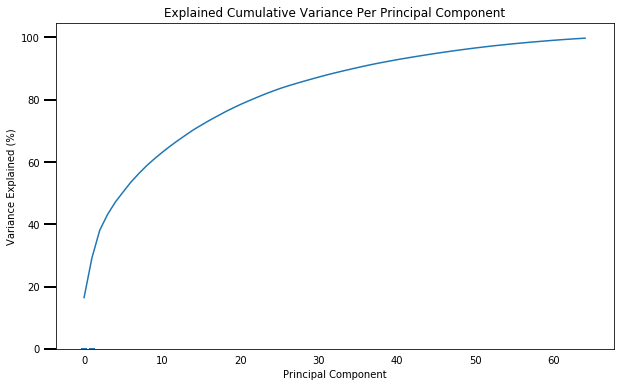

In [61]:
# Show explained variance of final selected components
scree_plot(pca)

In [62]:
# Reminder of dimensionality of original data
azdias.shape[1]

68

### Discussion 2.2: Perform Dimensionality Reduction

The default PCA generated around 65 components. At around 65 components 100% of the variance is explained, so there is no added benefit of addtional components after this point. I am actually slightly surprised the dimensionality has been reduced from only 68 to 65! I would have hoped PCA could explain more of the variance with fewer components?

Anyway, I will therefore be retaining the 65 top principal components for the next stage. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, I will map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. I will use the data dictionary document to help understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- I will investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, I will write a function that I can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when I interpret the tendencies of the discovered clusters.

Component 0 - Top 5 and bottom 5 feature weights
                        Feature weight
PLZ8_ANTG3                      0.2224
PLZ8_BAUMAX                     0.2158
CAMEO_INTL_2015_WEALTH          0.2023
ORTSGR_KLS9                     0.2016
EWDICHTE                        0.1996
FINANZ_MINIMALIST              -0.2078
KBA05_GBZ                      -0.2101
KBA05_ANTG1                    -0.2172
PLZ8_ANTG1                     -0.2215
MOBI_REGIO                     -0.2367


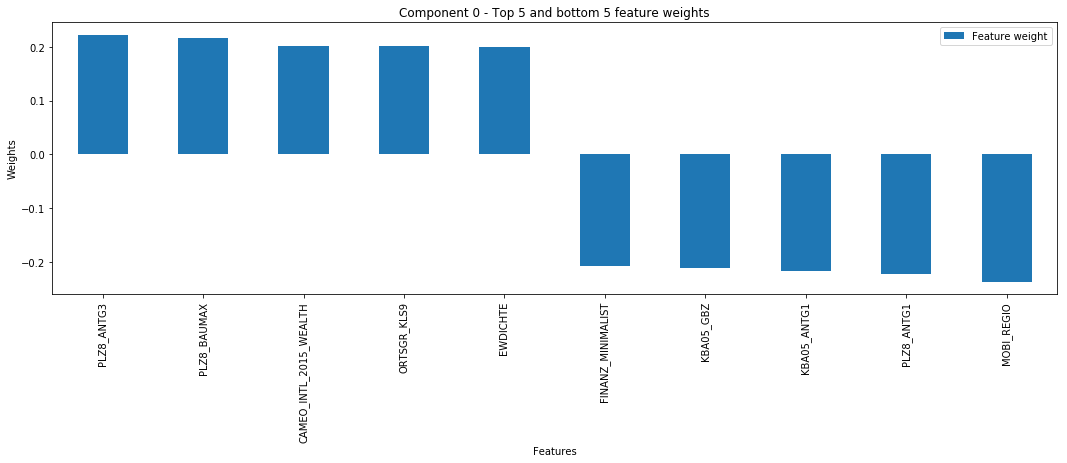

In [63]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
    
def features_of_component(component_num, pca, df):
    
    # Get selected component
    component = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys()).iloc[component_num]
    # Sort features by weights
    component = component.sort_values(ascending=False)
    # Extract top and bottom 5 feature weights for this component
    component = pd.concat([component.head(5), component.tail(5)])
    # Re-format
    component_df = component.to_frame()
    component_df = component_df.rename(columns={component_num: "Feature weight"})

    # Print weight values
    title = "Component " + str(component_num) + " - Top 5 and bottom 5 feature weights"
    print(title)
    print(component_df)
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (18,5))
    
    # Plot the feature weights of component
    component_df.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Weights")
    ax.set_xlabel("Features")
    ax.set_title(title)
    
features_of_component(0, pca, azdias)

So for this component 0, the definitions for the top 5 features with positive weights are the following:

- EWDICHTE: Density of households per square kilometer
- ORTSGR_KLS9: Size of community
- CAMEO_INTL_2015_WEALTH: German CAMEO: Wealth / Life Stage Typology, Wealthy Households
- PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region
- PLZ8_BAUMAX: Most common building type within the PLZ8 region

So for this component 0, the definitions for the bottom 5 features with negative weights are the following:

- KBA05_GBZ: Number of buildings in the microcell
- PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region
- MOBI_REGIO: Movement patterns
- KBA05_ANTG1: Number of 1-2 family houses in the microcell
- FINANZ_MINIMALIST: Financial typology, for each dimension

Looking at the top 5 features, these seem to be to do with:

- Size & density of community

Looking at the bottom 5 features, these seem to be to do with:

- Small occupancy households
- Size & density of community
- Movement patterns
- Types of finance available 

For the top 5, their relationship might be described as concerning large occupancy and community density.

For the bottom 5, the fact that these are all correlated with each other suggests some interesting relationships, for example something akin to 'high social mobility' these might describe people who live in small occupancy households, move around more often, and have a higher range of finance sources available. It makes some sense why these features would correlate with each other.

In terms of the top 5 relating to the bottom 5, we might make sense that the top 5 features which are associated with low income and large occupancy households, and it does make some sense that these are negatively correlated with the 'low density - high social mobility' features such as small occupancy, more financial means, and more mobile. Tho there are some small discripencies in this thesis regarding contrdictory features (ie low and high income features in top 5).

Component 1 - Top 5 and bottom 5 feature weights
                              Feature weight
ALTERSKATEGORIE_GROB                  0.2667
FINANZ_VORSORGER                      0.2387
SEMIO_ERL                             0.2337
SEMIO_LUST                            0.1879
RETOURTYP_BK_S                        0.1645
SEMIO_PFLICHT                        -0.2335
SEMIO_TRADV                          -0.2360
FINANZ_SPARER                        -0.2438
PRAEGENDE_JUGENDJAHRE_DECADE         -0.2581
SEMIO_REL                            -0.2597


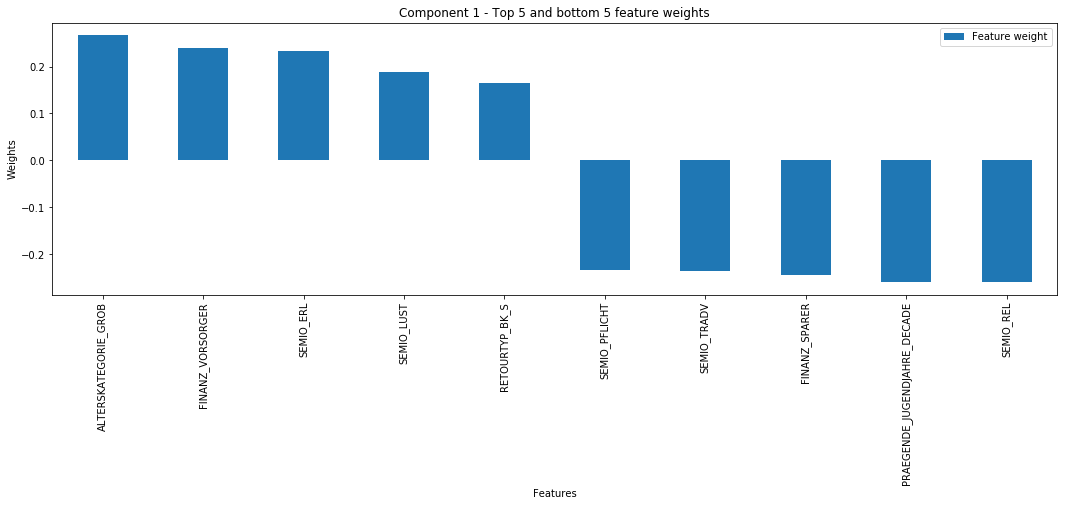

In [64]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

features_of_component(1, pca, azdias)

So for this component 1, the definitions for the top 5 features with positive weights are the following:

- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
- FINANZ_VORSORGER: Financial typology, for each dimension
- SEMIO_ERL: Personality typology, for each dimension
- SEMIO_LUST: Personality typology, for each dimension
- RETOURTYP_BK_S: Return type (ie type of shopper)

So for this component 1, the definitions for the bottom 5 features with negative weights are the following:

- SEMIO_PFLICHT: Personality typology, for each dimension
- SEMIO_TRADV: Personality typology, for each dimension
- FINANZ_SPARER: Financial typology, for each dimension
- PRAEGENDE_JUGENDJAHRE_DECADE: Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west) - Decade
- SEMIO_REL: Personality typology, for each dimension

So for the top 5, these seem to be related to:

- Age
- Shopper type
- Personality type

For the bottom 5 these seem to be related to:

- Personality type
- Financial options
- Social movement (by decade)

So with personality type being involved in both positive and negative correlations - its difficult to say what this might indicate. However this component does indicate an inverse correlation between age and social movement which could be interesting and makes some sense.

Component 2 - Top 5 and bottom 5 feature weights
                   Feature weight
SEMIO_VERT                 0.3468
SEMIO_SOZ                  0.2614
SEMIO_FAM                  0.2492
SEMIO_KULT                 0.2350
FINANZ_MINIMALIST          0.1594
SEMIO_RAT                 -0.2186
SEMIO_KRIT                -0.2769
SEMIO_DOM                 -0.3159
SEMIO_KAEM                -0.3385
ANREDE_KZ                 -0.3690


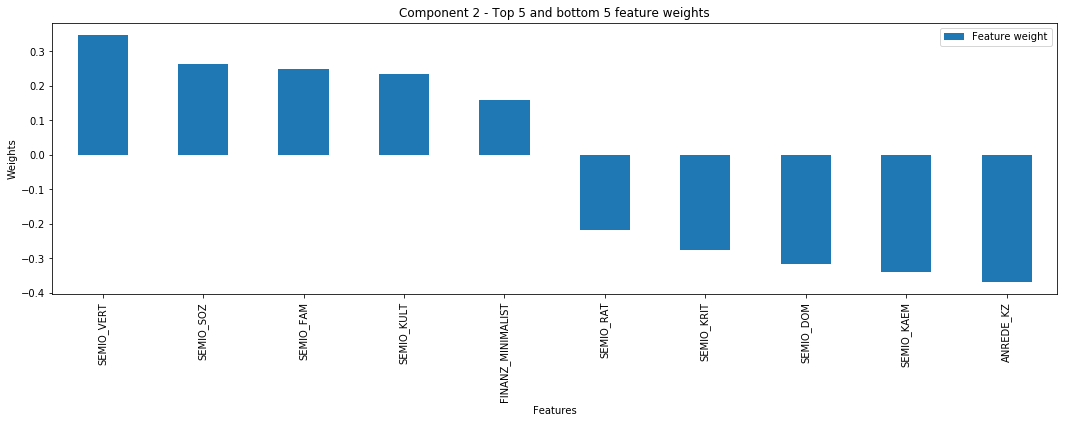

In [65]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

features_of_component(2, pca, azdias)

So for this component 2, the definitions for the top 5 features with positive weights are the following:

- SEMIO_VERT: Personality typology, for each dimension
- SEMIO_SOZ: Personality typology, for each dimension
- SEMIO_FAM: Personality typology, for each dimension
- SEMIO_KULT: Personality typology, for each dimension
- FINANZ_MINIMALIST: Financial typology, for each dimension

So for this component 2, the definitions for the bottom 5 features with negative weights are the following:

- SEMIO_RAT: Personality typology, for each dimension
- SEMIO_KRIT: Personality typology, for each dimension
- SEMIO_DOM: Personality typology, for each dimension
- SEMIO_KAEM: Personality typology, for each dimension
- ANREDE_KZ: Gender

Given most of these features from both the most positive and negative relationships to this compoent relate to personality type, its is more difficult to infer insights for this component.

### Discussion 2.3: Interpret Principal Components

I investigated the first 3 principle components, and for each looked at their top and bottom 5 features.

For the first component, there appeared to be several interesting correlations between the strongest features, such as positive correlations between size and density features, and negative correlations between large occupancy/high density features v low density & low occupancy & high financial and physical mobility. 

For the second and third components, the relationships between the strongest features became harder to infer any obvious meaning at this stage.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

I have assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- I will use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, I will compute the average difference from each point to its assigned cluster's center. 
- I will perform the above two steps for a number of different cluster counts. I can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. I will use this fact to select a final number of clusters in which to group the data. 
- Once I have selected a final number of clusters to use, I will re-fit a KMeans instance to perform the clustering operation. 

In [66]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
    
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)

    # Obtain a score related to the model fit
    score = np.abs(model.score(data))

    return score

Compute time: 53.22 mins


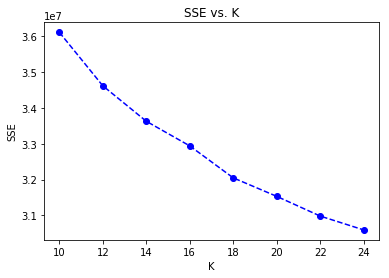

In [150]:
# Investigate the change in within-cluster distance across number of clusters.

start_compute = time.time()

k_scores = []
k_vals = list(range(10,26,2))

# Calculate scores for a range of k values
for k in k_vals:
    k_scores.append(get_kmeans_score(pca_components_azdias, k))

# Plot k vals (clusters) v score (SSE)
plt.plot(k_vals, k_scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

print("Compute time: %s mins" % np.round(((time.time() - start_compute)/60),2))

Using the elbow method to determine the optimal number of clusters, we can see no indication in a sudden drop in slope as clusters increase (indicating the most optimal number of clusters). Therefore in the absence of guidence from this method, I will choose 20 clusters.

In [67]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

start_compute = time.time()

# Instantiate chosen kmeans model
kmeans = KMeans(n_clusters=20)
kmeans_model = kmeans.fit(pca_components_azdias)
# Fit & predict on population data
kmeans_clusters_azdias = kmeans_model.predict(pca_components_azdias)

print("Compute time: %s mins" % np.round(((time.time() - start_compute)/60),2))

Compute time: 8.23 mins


### Discussion 3.1: Apply Clustering to General Population

Using the eblow method to try to determine optimum cluster levels, I was unable to find an obvious candidate cluster value. I chose a cluster value of 20.

### Step 3.2: Apply All Steps to the Customer Data

Now that I have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. I am going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, I will interpret how the general population fits apply to the customer data.

In [68]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
# Initial dimensions
customers.shape

(191652, 85)

In [69]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean data (including remove columns)
customers = clean_data(customers)
# Separate outlier rows
# (Separate out 'outlier rows' from customer dataset using same criteria as was applied to general population dataset)
# - Get normal rows indexes
normal_rows_indexes_customers = customers.isnull().sum(axis = 1)[customers.isnull().sum(axis = 1) <= 25]
# - Get outlier rows indexes
outlier_rows_indexes_customers = customers.isnull().sum(axis = 1)[customers.isnull().sum(axis = 1) > 25] 
# - Get normal rows data subset
customers = customers.drop(outlier_rows_indexes_customers.index)
# - Get outlier rows data subset
outlier_customers = customers.drop(normal_rows_indexes_customers.index)
# Current dimensions
customers.shape

(141713, 68)

In [93]:
# Number of customers in the outlier group
outlier_customers

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE


In [70]:
# Transform features - customer data (1)
# - Impute nans
customers = impute_nans(customers)
# Check Nans replaced
current_nans = customers.isnull().values.sum()
(current_nans / total_cells) * 100

0.0

In [71]:
# Dimensions after cleaning
customers.shape

(141713, 68)

In [72]:
# Check match of columns with original
azdias.shape

(797961, 68)

In [73]:
# Transform features - customer data (2)
# - Scale features using existing general population scaler
customers_np = scaler.transform(customers)
# - Transform features to PCA components using general population PCA
pca_components_customers = pca.transform(customers_np)
# - Predict cluster labels for customer data using kmeans model from general population 
kmeans_clusters_customers = kmeans_model.predict(pca_components_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

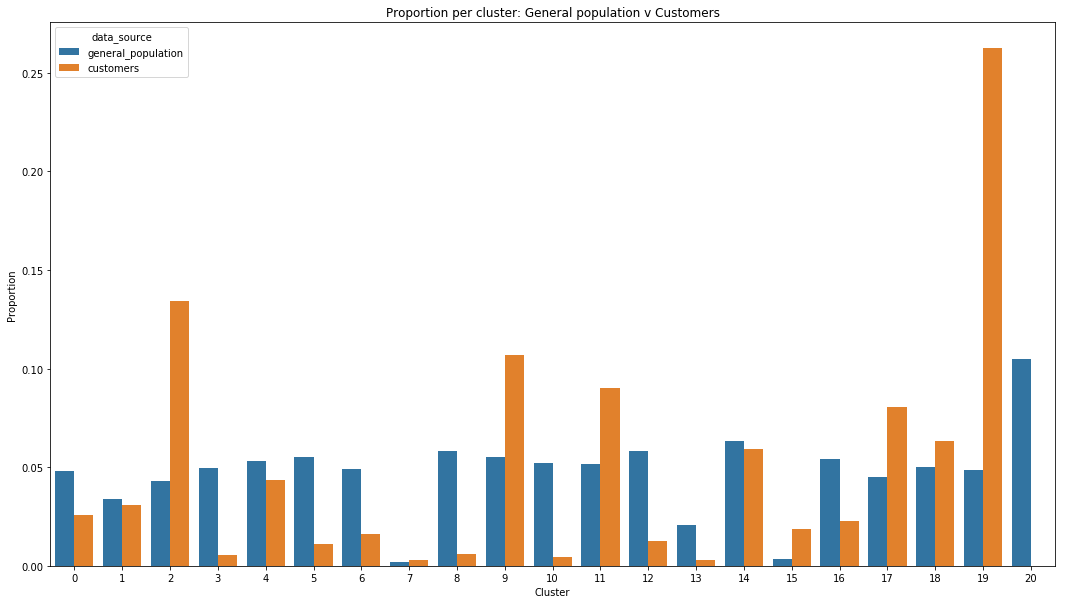

In [91]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Proportion of data per cluster - population data
# Value counts (Add outlier rows extracted previously for excessive nans as additional 'cluster' 20 then normalise)
azdias_count_per_cluster = pd.Series(kmeans_clusters_azdias).value_counts(sort=False)
azdias_count_per_cluster[20] = outlier_rows_df.shape[0]
azdias_count_per_cluster = azdias_count_per_cluster / azdias_count_per_cluster.sum()
# Construct dataframe
azdias_cpc_dictionary = {'proportion': azdias_count_per_cluster, 'data_source': 'general_population'}
azdias_cpc_df = pd.DataFrame(azdias_cpc_dictionary)

# Proportion of data per cluster - customer data
# Value counts (Add outlier rows extracted previously for excessive nans as additional 'cluster' 20 then normalise)
customer_count_per_cluster = pd.Series(kmeans_clusters_customers).value_counts(sort=False)
customer_count_per_cluster[20] = outlier_customers.shape[0]
customer_count_per_cluster = customer_count_per_cluster / customer_count_per_cluster.sum()
# Construct dataframe
customer_cpc_dictionary = {'proportion': customer_count_per_cluster, 'data_source': 'customers'}
customer_cpc_df = pd.DataFrame(customer_cpc_dictionary)

# Join proportions
all_proportions_df = pd.concat([azdias_cpc_df, customer_cpc_df])

# Plot histogram to compare cluster count distribution differeces between datasets
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(ax=ax, x=all_proportions_df.index, y = all_proportions_df.proportion, hue=all_proportions_df.data_source)
ax.set_xlabel('Cluster')
ax.set_ylabel('Proportion')
ax.set_title('Proportion per cluster: General population v Customers');

In [92]:
outlier_customers.shape[0]

0

In [114]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster 19 seems to be a good candidate, lets examine its top 5 features
# Co-ordinates (vector) of center for cluster 19 in 65 dimensions of PCA component space
cluster19 = kmeans_model.cluster_centers_[19]
# Convert to series
cluster19 = pd.Series(cluster19)
# Transform cluster19 to co-ordinates (vector) in original 68 dimension feature space
cluster19 = scaler.inverse_transform(pca.inverse_transform(cluster19))
cluster19 = pd.Series(cluster19).round(2)
cluster19 = cluster19.sort_values(ascending=False)
cluster19.index = list(azdias.columns.values)
# For this cluster, represented as a vector in the original 68 dimension feature space
# Let's look at the 5 biggest component features by magnitude in this vector
print(cluster19.head())

ALTERSKATEGORIE_GROB    1992.68
ANREDE_KZ                695.55
FINANZ_MINIMALIST         22.57
FINANZ_SPARER              8.48
FINANZ_VORSORGER           6.61
dtype: float64


So the 2 most significant features in this cluster/vector are:

- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
- ANREDE_KZ: Gender

Let's compare the values for these between the two datasets:

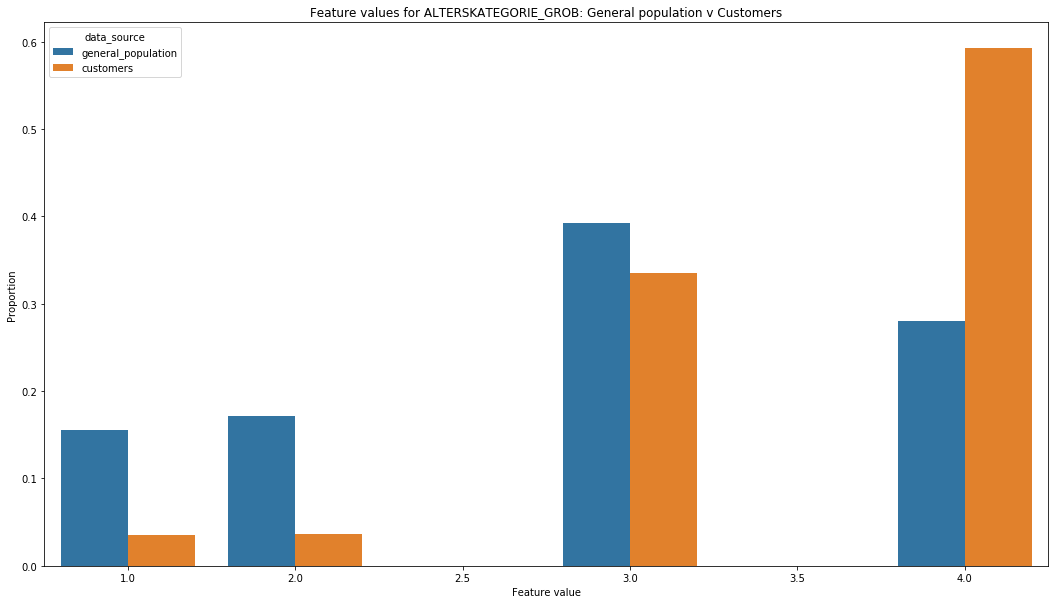

In [128]:
def compare_feature_values(feature):

    # Construct dataframe of feature value proportions for population data
    azdias_feature_values = azdias[feature].value_counts()
    azdias_feature_proportions =  azdias_feature_values / azdias_feature_values.sum()
    azdias_feature_dictionary = {'proportion': azdias_feature_proportions, 'data_source': 'general_population'}
    azdias_feature_df = pd.DataFrame(azdias_feature_dictionary)

    # Construct dataframe of feature value proportions for customer data
    customers_feature_values = customers[feature].value_counts()
    customers_feature_proportions =  customers_feature_values / customers_feature_values.sum()
    customers_feature_dictionary = {'proportion': customers_feature_proportions, 'data_source': 'customers'}
    customers_feature_df = pd.DataFrame(customers_feature_dictionary)

    # Join proportions
    all_proportions_feature_df = pd.concat([azdias_feature_df, customers_feature_df])

    # Plot histogram to compare cluster count distribution differeces between datasets
    fig, ax = plt.subplots(figsize=(18,10))
    sns.barplot(ax=ax, x=all_proportions_feature_df.index, y = all_proportions_feature_df.proportion, hue=all_proportions_feature_df.data_source)
    ax.set_xlabel('Feature value')
    ax.set_ylabel('Proportion')
    ax.set_title('Feature values for ' + feature + ': General population v Customers');
    
compare_feature_values('ALTERSKATEGORIE_GROB')

So it seems what differentiates customers from the general population for this feature ALTERSKATEGORIE_GROB is that the general population has more values of 1, 2 & 3 - and customer have more of a value of 4.

Looking at the interpretation of the values for ALTERSKATEGORIE_GROB:

- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old
-  9: uniformly distributed

This seems to suggest that more of this companies customers are in the 60+ age bracket than is typical for the general population - therefore it might be good for the company to target people who are 60+ years in age.

Let's now look at the gender feature ANREDE_KZ...

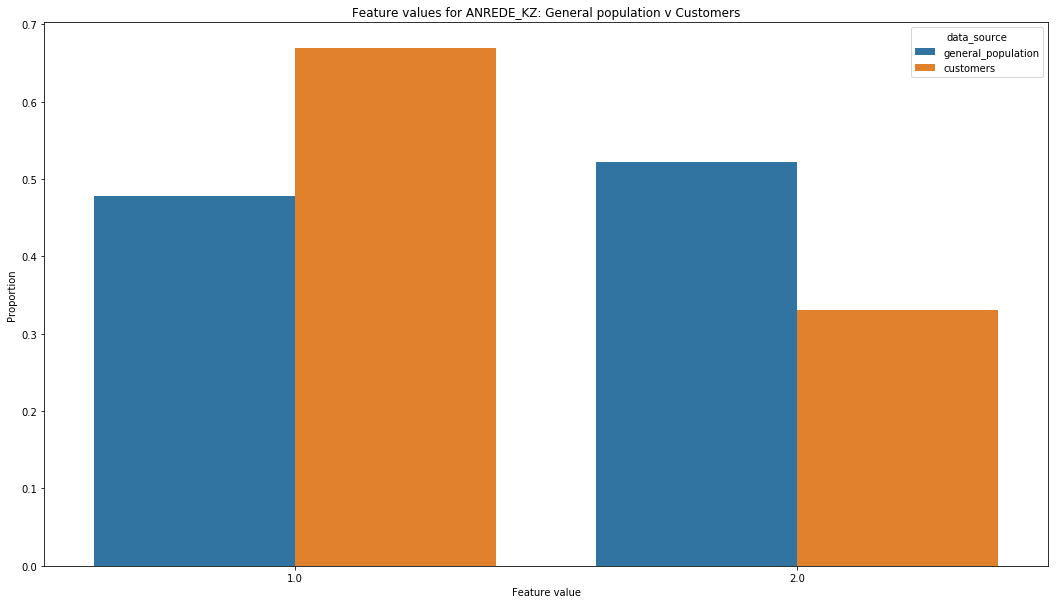

In [129]:
# Compare values for ANREDE_KZ
compare_feature_values('ANREDE_KZ')

So it seems what differentiates customers from the general population for this feature ANREDE_KZ is that the general population has more values of 2 - and customer have more of a value of 1.

Looking at the interpretation of the values for ANREDE_KZ:

- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: male
-  2: female

This seems to suggest that more of this companies customers are male than is typical for the general population - therefore it might be good for the company to target more males than females.

In [127]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 8 seems to be a good candidate, lets examine its top 5 features
# Co-ordinates (vector) of center for cluster 8 in 65 dimensions of PCA component space
cluster8 = kmeans_model.cluster_centers_[8]
# Convert to series
cluster8 = pd.Series(cluster8)
# Transform cluster8 to co-ordinates (vector) in original 68 dimension feature space
cluster8 = scaler.inverse_transform(pca.inverse_transform(cluster8))
cluster8 = pd.Series(cluster8).round(2)
cluster8 = cluster8.sort_values(ascending=False)
cluster8.index = list(azdias.columns.values)
# For this cluster, represented as a vector in the original 68 dimension feature space
# Let's look at the 5 biggest component features by magnitude in this vector
print(cluster8.head())

ALTERSKATEGORIE_GROB    1992.53
ANREDE_KZ                498.16
FINANZ_MINIMALIST         14.62
FINANZ_SPARER              8.76
FINANZ_VORSORGER           7.11
dtype: float64


So the it seems again 2 most significant features in this cluster/vector are:

- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
- ANREDE_KZ: Gender

But we have already examined these. Let us then look at the differences between the next two most significant features:
    
- FINANZ_MINIMALIST: Financial typology, for each dimension
- FINANZ_SPARER: Financial typology, for each dimension

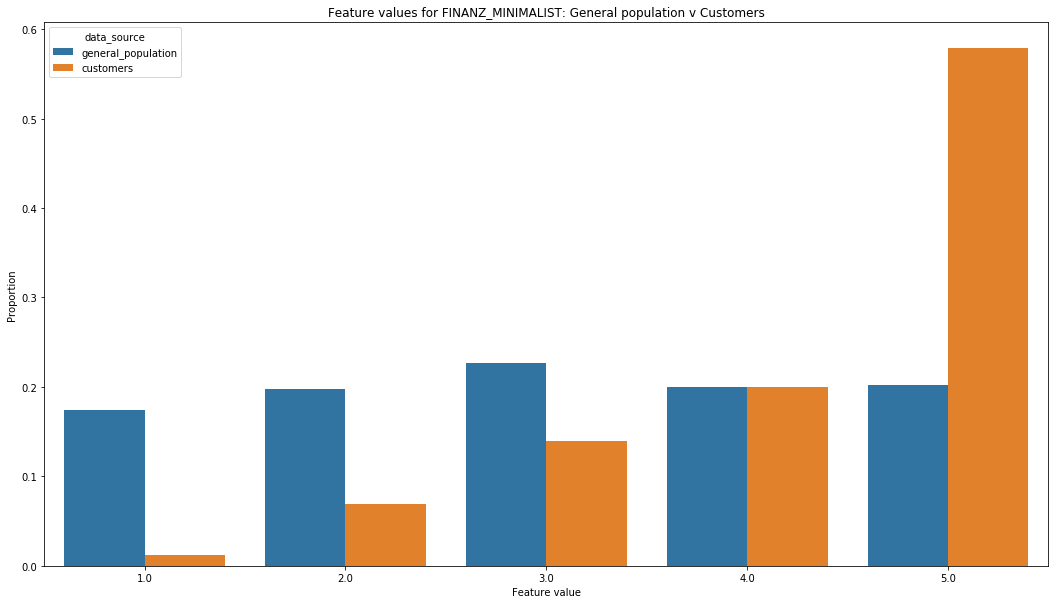

In [130]:
# Compare values for FINANZ_MINIMALIST
compare_feature_values('FINANZ_MINIMALIST')

So it seems what differentiates customers from the general population for this feature FINANZ_MINIMALIST is that the general population has more values of 1-3 - and customer have more of a value of 5.

Looking at the interpretation of the values for FINANZ_MINIMALIST:

Financial typology, for each dimension:
- -1: unknown
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

And code:
- MINIMALIST: low financial interest
- SPARER: money-saver
- VORSORGER: be prepared
- ANLEGER: investor
- UNAUFFAELLIGER: inconspicuous
- HAUSBAUER: home ownership

This seems to suggest that those with very high to average of type 'low financial interest' are under-represented in the customers of the company.

Let us now look at FINANZ_SPARER...

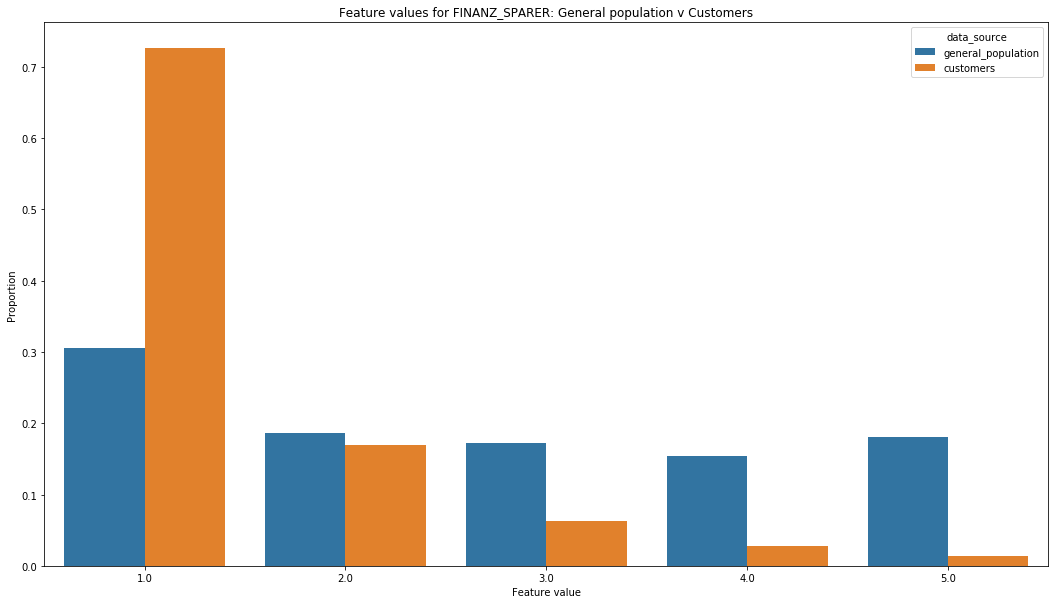

In [131]:
# Compare values for FINANZ_SPARER
compare_feature_values('FINANZ_SPARER')

So it seems what differentiates customers from the general population for this feature FINANZ_SPARER is that the general population has more values of 2-5 - and customer have more of a value of 1.

Looking at the interpretation of the values for FINANZ_SPARER:

Financial typology, for each dimension:
- -1: unknown
- 1: very high
- 2: high
- 3: average
- 4: low
- 5: very low

And code:

- MINIMALIST: low financial interest
- SPARER: money-saver
- VORSORGER: be prepared
- ANLEGER: investor
- UNAUFFAELLIGER: inconspicuous
- HAUSBAUER: home ownership

This seems to suggest that those with high to low of type 'money-saver' are under-represented in the customers of the company.

## Conclusion: Comparing Customer Data to Demographics Data

So from the clustering analysis I looked to two clusters (19 & 8) that were over-represented & under-represented in the customer data (respectively).

From my analysis of the underlying features of these clusters, I found evidence to suggest the following:

**Segments of German population that were more popular with the mail order company**

- People older that 60 years old
- Men
- Those with very low 'low financial interest' Financial typology
- Those with very high 'money-saver' Financial typology

**Segments of German population that were less popular with the mail order company**

- People under 60 years old (especially under 45)
- Women
- Those with very high to average 'low financial interest' Financial typology
- Those with high to low 'money-saver' Financial typology